In [1]:
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from IPython.display import clear_output

import matplotlib as mpl
import matplotlib.pyplot as plt

import data_parser
%matplotlib inline

In [2]:
# CUDA
if torch.cuda.is_available():
    dev = "cuda:0"
    print("CUDA avaiable")
else:  
    dev = "cpu"
    print("CUDA not avaiable")
device = torch.device(dev)

CUDA avaiable


In [3]:
def live_plot_X_y(X, y, pred=None, epoch=None, loss=None, r2=None, mer=None):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(20, 4))
    range(len(X))
    ax.plot(X.detach().numpy(), y.detach().numpy())
    if pred != None:
        text_kwargs = dict(fontsize=18, )
        ax.plot(X.detach().numpy(), pred.detach().numpy())
        plt.text(0, y.max(), 'Batch %d Loss: %.4f R2 : %.4f Max Error Rate : %.4f' % (epoch, loss, r2, mer), **text_kwargs)

    plt.show();
    
def plot_X_y(X, y, pred=None, epoch=None, loss=None, r2=None, mer=None):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(20, 4))
    range(len(X))
    ax.plot(X.detach().numpy(), y.detach().numpy())
    if pred != None:
        text_kwargs = dict(fontsize=18, )
        ax.plot(X.detach().numpy(), pred.detach().numpy())
        plt.text(0, y.max(), 'Final Results Loss: %.4f R2 : %.4f Max Error Rate : %.4f' % (loss, r2, mer), **text_kwargs)

    plt.show();

In [4]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 500)
        self.fc4 = nn.Linear(500, out_features)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

def initialize_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias.data)

In [5]:
class data_processor():
    def __init__(self):
        self.dict = {}
    
    def initial_normalize(self, X, y):
        self.dict['X_std'] = X.std(dim=0)
        self.dict['X_mean'] = X.mean(dim=0)
        self.dict['y_std'] = y.std(dim=0)
        self.dict['y_mean'] = y.mean(dim=0)
        # new_X = (X - self.dict['X_mean']) / self.dict['X_std']
        # new_y = (y - self.dict['y_mean']) / self.dict['y_std']
        # return new_X, new_y
        return
    
    def normalize(self, X=None, y=None):
        new_X, new_y = None, None
        if X is not None:
            new_X = (X - self.dict['X_mean']) / self.dict['X_std']
        if y is not None:
            new_y = (y - self.dict['y_mean']) / self.dict['y_std']
        return new_X, new_y
    
    def denormalize(self, X=None, y=None):
        original_X, original_y = None, None
        if X is not None:
            original_X = X * self.dict['X_std'] + self.dict['X_mean']
        if y is not None:    
            original_y = y * self.dict['y_std'] + self.dict['y_mean']
        return original_X, original_y

In [6]:
df = data_parser.calculate_amp_phase(data_parser.data_parse(), unwrap=True)

In [51]:
# Randomly shuffle the indices
index_list = list(dict.fromkeys(df.index.get_level_values(0)))
random.seed(42)
np.random.shuffle(index_list)

# Split the indices into 80% training set, 10% testing set and 10% validation set
train_idx = index_list[:int(len(index_list) * 0.8)]
test_idx = index_list[int(len(index_list) * 0.8):int(len(index_list) * 0.9)]
val_idx = index_list[int(len(index_list) * 0.9):]

In [81]:
def train(df, output_col, train_idx, val_idx, device):
    # Define network feature numbers
    input_cols = ["W", "Trap", "Length"]
    in_features = 3
    out_features = 501

    X_train, y_train = torch.Tensor(df.loc[train_idx][input_cols].to_numpy()).to(device), torch.Tensor(df.loc[train_idx][output_col].to_numpy().reshape(-1, 1)).to(device)
    X_val, y_val = torch.Tensor(df.loc[val_idx][input_cols].to_numpy()).to(device), torch.Tensor(df.loc[val_idx][output_col].to_numpy().reshape(-1, 1)).to(device)

    # Reduce the second dimension by torch.mean
    X_train, y_train = torch.mean(X_train.reshape(-1, out_features, in_features), dim=1), y_train.reshape(-1, out_features)
    X_val, y_val = torch.mean(X_val.reshape(-1, out_features, in_features), dim=1), y_val.reshape(-1, out_features)

    # Generate frequency label for plotting
    train_idx_example = train_idx[0]
    F = torch.Tensor(df.loc[train_idx_example]['F']).reshape(-1, 1)

    # Preprocess the data
    dp = data_processor()
    dp.initial_normalize(torch.cat((X_train, X_val)), torch.cat((y_train, y_val)))
    X_train_norm, y_train_norm = dp.normalize(X_train, y_train)
    X_val_norm, y_val_norm = dp.normalize(X_val, y_val)

    model = MLP(in_features, out_features)
    learning_rate = 0.001
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model = model.to(device)
    criterion = nn.L1Loss()

    initialize_weights(model)

    num_epochs = 10000

    for epoch in range(num_epochs):

        # Clear the gradients
        optimizer.zero_grad()

        # Forward propagation
        outputs = model(X_train_norm)

        # Calculate the loss function
        loss = criterion(outputs, y_train_norm)

        # Backward propagation
        loss.backward()

        # Update parameters
        optimizer.step()

        # Validation
        if epoch % 100 == 99: 
            with torch.no_grad():

                predictions = model(X_val_norm)

                _, predictions = dp.denormalize(y=predictions)
                _, outputs = dp.denormalize(y=outputs)

                # Import the r2_score function
                from sklearn.metrics import r2_score

                # Compute the R^2 score
                r2 = r2_score(predictions.detach().cpu().numpy(), y_val.detach().cpu().numpy())

                # Compute the max error rate
                mer = torch.max(torch.abs(predictions - y_val) / y_val)


                # Plot training results
                i = random.randint(0, y_train.shape[0]-1)
                live_plot_X_y(F.cpu(), y_train.cpu()[i,:], outputs.cpu()[i,:], epoch + 1, loss, r2, mer)

                # Plot validation results
                # i = random.randint(0, y_val.shape[0]-1)
                # live_plot_X_y(F.cpu(), y_val.cpu()[i,:], predictions.cpu()[i,:], epoch + 1, loss, r2, mer)

    
    return model, dp

def test(model, df, dp, output_col, test_idx , device):
    # Define network feature numbers
    input_cols = ["W", "Trap", "Length"]
    in_features = 3
    out_features = 501
    F = torch.Tensor(df.loc[train_idx_example]['F']).reshape(-1, 1)
    
    X_test, y_test = torch.Tensor(df.loc[test_idx][input_cols].to_numpy()).to(device), torch.Tensor(df.loc[test_idx][output_col].to_numpy().reshape(-1, 1)).to(device)
    X_test, y_test = torch.mean(X_test.reshape(-1, out_features, in_features), dim=1), y_test.reshape(-1, out_features)
    X_test_norm, _ = dp.normalize(X=X_test)

    with torch.no_grad():

        # Make predictions on the test data
        predictions = model(X_test_norm)
        _, predictions = dp.denormalize(y=predictions)

        # Calculate the loss function
        test_loss = criterion(predictions, y_test)

        # Track the loss value 
        test_loss = test_loss.item()  

        # Compute the R^2 score
        r2 = r2_score(predictions.detach().cpu().numpy(), y_test.detach().cpu().numpy())

        # Compute the max error rate
        mer = torch.max(torch.abs(predictions - y_test) / y_test)

        plot_X_y(F.cpu(), y_test.cpu()[0,:], predictions.cpu()[0,:], 0, test_loss, r2, mer)
    
    return predictions

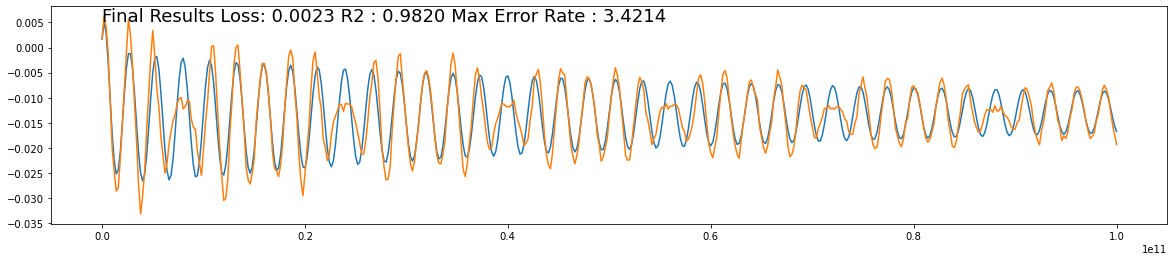

In [82]:
SR11_model, SR11_dp = train(df, 'SR(1,1)', train_idx, val_idx, device)
SR11_predictions = test(SR11_model, df, SR11_dp, 'SR(1,1)', test_idx, device)

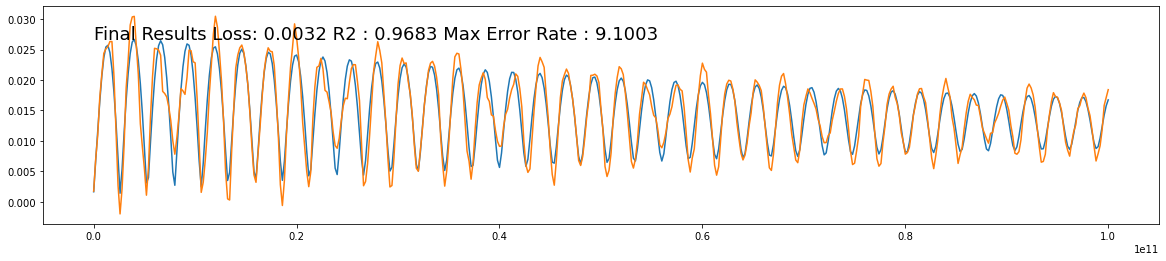

In [83]:
A11_model, A11_dp = train(df, 'A(1,1)', train_idx, val_idx, device)
A11_predictions = test(A11_model, df, A11_dp, 'A(1,1)', test_idx, device)

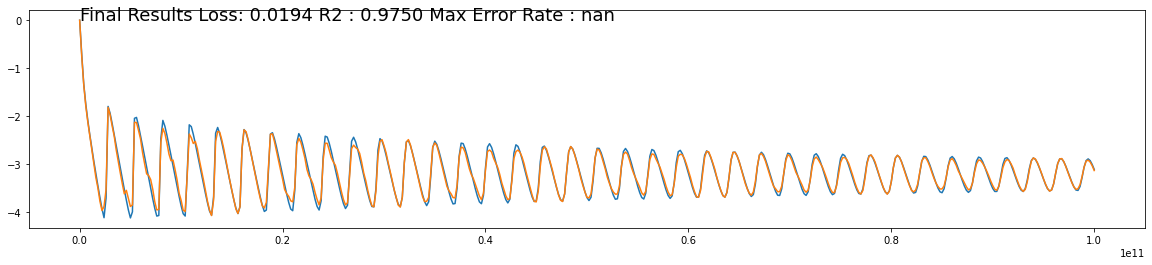

In [84]:
P11_model, P11_dp = train(df, 'P(1,1)', train_idx, val_idx, device)
P11_predictions = test(P11_model, df, P11_dp, 'P(1,1)', test_idx, device)

In [85]:
F = torch.Tensor(df.loc[train_idx_example]['F']).reshape(-1, 1)
train_idx_example = train_idx[0]


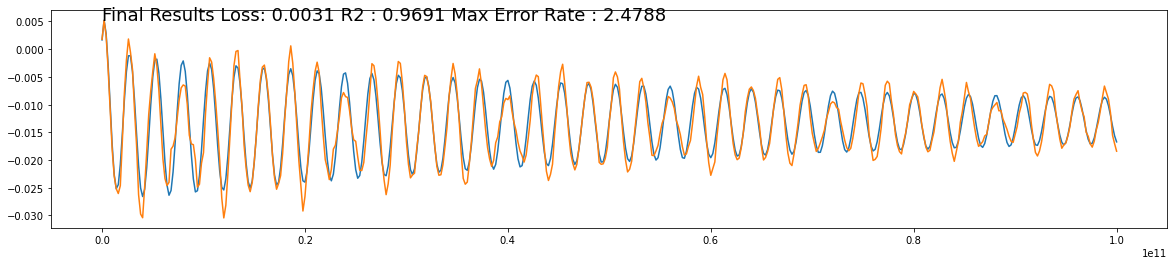

In [86]:
predictions = A11_predictions * torch.cos(P11_predictions)
y_test = torch.Tensor(df.loc[test_idx]['SR(1,1)'].to_numpy().reshape(-1, 501)).to(device)
with torch.no_grad():
    criterion = nn.L1Loss()
    test_loss = criterion(predictions, y_test)
    # Calculate the loss function
    test_loss = criterion(predictions, y_test)

    # Track the loss value 
    test_loss = test_loss.item()  

    # Compute the R^2 score
    r2 = r2_score(predictions.detach().cpu().numpy(), y_test.detach().cpu().numpy())

    # Compute the max error rate
    mer = torch.max(torch.abs(predictions - y_test) / y_test)

    plot_X_y(F.cpu(), y_test.cpu()[0,:], predictions.cpu()[0,:], 0, test_loss, r2, mer)
    

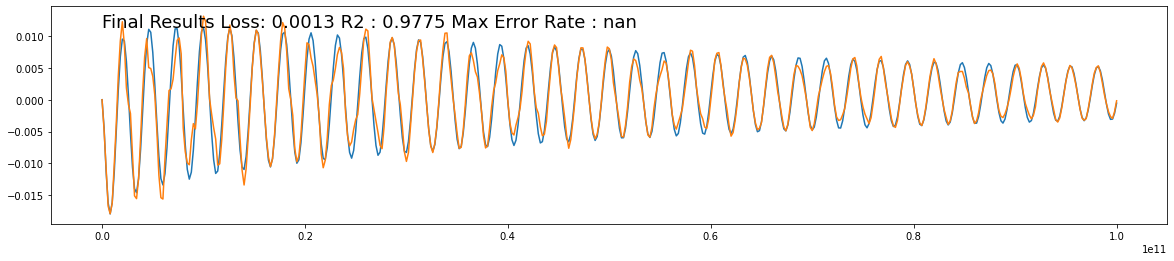

In [87]:
predictions = A11_predictions * torch.sin(P11_predictions)
y_test = torch.Tensor(df.loc[test_idx]['SI(1,1)'].to_numpy().reshape(-1, 501)).to(device)
with torch.no_grad():
    criterion = nn.L1Loss()
    test_loss = criterion(predictions, y_test)
    # Calculate the loss function
    test_loss = criterion(predictions, y_test)

    # Track the loss value 
    test_loss = test_loss.item()  

    # Compute the R^2 score
    r2 = r2_score(predictions.detach().cpu().numpy(), y_test.detach().cpu().numpy())

    # Compute the max error rate
    mer = torch.max(torch.abs(predictions - y_test) / y_test)

    plot_X_y(F.cpu(), y_test.cpu()[0,:], predictions.cpu()[0,:], 0, test_loss, r2, mer)
    

In [66]:
SR11

tensor([[1.6634e-03, 5.2097e-03, 2.8183e-03,  ..., -1.3920e-02, -1.5625e-02, -1.6729e-02],
        [4.6519e-03, -1.0048e-01, -1.6104e-01,  ..., -9.1550e-02, -9.1625e-02, -9.3834e-02],
        [2.7082e-03, -1.6928e-02, -7.4946e-02,  ..., -7.1332e-02, -6.6937e-02, -6.0431e-02],
        ...,
        [1.0487e-03, -7.0036e-03, -3.8927e-02,  ..., -1.0658e-01, -1.2147e-01, -1.3213e-01],
        [1.6070e-03, -1.2265e-02, -5.9698e-02,  ..., -1.0095e-01, -8.7518e-02, -7.6286e-02],
        [9.8177e-04, -3.4132e-03, -2.3914e-02,  ..., -5.8178e-02, -6.6148e-02, -7.8178e-02]],
       device='cuda:0')

In [36]:
# Get the mean and standard of each case
X_train, y_train = torch.Tensor(df.loc[train_idx][input_cols].to_numpy()).to(device), torch.Tensor(df.loc[train_idx][output_col].to_numpy().reshape(-1, 1)).to(device)
X_test, y_test = torch.Tensor(df.loc[test_idx][input_cols].to_numpy()).to(device), torch.Tensor(df.loc[test_idx][output_col].to_numpy().reshape(-1, 1)).to(device)
X_val, y_val = torch.Tensor(df.loc[val_idx][input_cols].to_numpy()).to(device), torch.Tensor(df.loc[val_idx][output_col].to_numpy().reshape(-1, 1)).to(device)

# Reduce the second dimension by torch.mean
X_train, y_train = torch.mean(X_train.reshape(-1, out_features, in_features), dim=1), y_train.reshape(-1, out_features)
X_test, y_test = torch.mean(X_test.reshape(-1, out_features, in_features), dim=1), y_test.reshape(-1, out_features)
X_val, y_val = torch.mean(X_val.reshape(-1, out_features, in_features), dim=1), y_val.reshape(-1, out_features)

y_train = torch.cat((torch.cat((y_train, )).mean(dim=1).reshape(-1,1), torch.cat((y_train, )).std(dim=1).reshape(-1,1)), dim=-1)
y_test = torch.cat((torch.cat((y_test, )).mean(dim=1).reshape(-1,1), torch.cat((y_test, )).std(dim=1).reshape(-1,1)), dim=-1)
y_val = torch.cat((torch.cat((y_val, )).mean(dim=1).reshape(-1,1), torch.cat((y_val, )).std(dim=1).reshape(-1,1)), dim=-1)

In [37]:
class mean_std_network(nn.Module):
    def __init__(self, in_features, out_features):
        super(mean_std_network, self).__init__()
        self.fc1 = nn.Linear(in_features, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, out_features)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [40]:
norm_model = mean_std_network(in_features, 2)
learning_rate = 0.001
optimizer = optim.Adam(norm_model.parameters(), lr=learning_rate)
norm_model = norm_model.to(device)
criterion = nn.L1Loss()

initialize_weights(norm_model)

num_epochs = 10000

for epoch in range(num_epochs):
    
    # Clear the gradients
    optimizer.zero_grad()
    
    # Forward propagation
    outputs = norm_model(X_train_norm)

    # Calculate the loss function
    loss = criterion(outputs, y_train)

    # Backward propagation
    loss.backward()

    # Update parameters
    optimizer.step()
    
    # Validation
    if epoch % 100 == 99: 
        with torch.no_grad():
            
            predictions = norm_model(X_val_norm)
            loss = criterion(predictions, y_val)
            
            # Compute the max error rate
            mer, _ = torch.max(torch.abs(predictions - y_val), dim=0)
            
            print("Epoch %d loss: %.4f max error: %.4f, %.4f" % (epoch + 1, loss.item(), mer[0], mer[1]))
            
            # Plot validation results
            # i = random.randint(0, y_val.shape[0]-1)
            # live_plot_X_y(F.cpu(), y_val.cpu()[i,:], predictions.cpu()[i,:], epoch + 1, loss, r2, mer)

In [ ]:
model = MLP(in_features, out_features)
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model = model.to(device)
criterion = nn.L1Loss()

initialize_weights(model)

num_epochs = 10000

for epoch in range(num_epochs):
    
    # Clear the gradients
    optimizer.zero_grad()
    
    # Forward propagation
    outputs = model(X_train_norm)

    # Calculate the loss function
    loss = criterion(outputs, y_train_norm)

    # Backward propagation
    loss.backward()

    # Update parameters
    optimizer.step()
    
    # Validation
    if epoch % 100 == 99: 
        with torch.no_grad():
            
            predictions = model(X_val_norm)

            _, predictions = dp.denormalize(y=predictions)
            _, outputs = dp.denormalize(y=outputs)

            # Import the r2_score function
            from sklearn.metrics import r2_score
            
            # Compute the R^2 score
            r2 = r2_score(predictions.detach().cpu().numpy(), y_val.detach().cpu().numpy())
            
            # Compute the max error rate
            mer = torch.max(torch.abs(predictions - y_val) / y_val)
            
            
            # Plot training results
            i = random.randint(0, y_train.shape[0]-1)
            live_plot_X_y(F.cpu(), y_train.cpu()[i,:], outputs.cpu()[i,:], epoch + 1, loss, r2, mer)
            
            # Plot validation results
            # i = random.randint(0, y_val.shape[0]-1)
            # live_plot_X_y(F.cpu(), y_val.cpu()[i,:], predictions.cpu()[i,:], epoch + 1, loss, r2, mer)
            
# Testing

with torch.no_grad():

    # Make predictions on the test data
    predictions = model(X_test_norm)

    # Calculate the loss function
    test_loss = criterion(predictions, y_test_norm)

    # Track the loss value 
    test_loss = test_loss.item()  

    _, predictions = dp.denormalize(y=predictions)
    
     # Compute the R^2 score
    r2 = r2_score(predictions.detach().cpu().numpy(), y_test.detach().cpu().numpy())

    # Compute the max error rate
    mer = torch.max(torch.abs(predictions - y_test) / y_test)
    
    plot_X_y(F.cpu(), y_test.cpu()[0,:], predictions.cpu()[0,:], 0, test_loss, r2, mer)

